# Tarea 2 Procesamiento de Lenguaje Natural

Estudiante: Sofía Vits
Profesora: María Paz Raveau
Fecha entrega: 3 de agosto 2025

### Introducción

En este trabajo se diagnosticarán los tópicos presentes en un subset de la base de datos "El Chile que Queremos", utilizando topic modeling y clustering.

### Desarrollo

#### Carga de librerías

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfre

In [ ]:
! pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import nltk
import string

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
from itertools import compress
from nltk import word_tokenize
import re

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import stanza
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json


INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Otras librerías utilizadas en la tarea 2:

spacy: [Fuente](https://spacy.io/)

Descripción breve: spaCy es una librería de procesamiento de lenguaje natural, diseñada para su uso en producción (no está creada para propósitos de investigación), facilitando el procesamiento de grandes volúmenes de texto. En este trabajo se usará para filtrar sustantivos, adjetivos y verbos presentes en la base de datos "El Chile que Queremos".

#### Carga de archivo y pre-procesamiento

In [ ]:
ecqq = pd.read_csv('ecqq.csv', sep='delimiter', on_bad_lines='warn')

/tmp/ipython-input-5-1315084596.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ecqq = pd.read_csv('ecqq.csv', sep='delimiter', on_bad_lines='warn')


In [ ]:
ecqq.shape

(10203, 1)

In [ ]:
ecqq.head()

,P2_1_B
0,0\tse necesitan pensiones dignas a los adultos...
1,"1\tel acceso a la salud sea de calidad, con di..."
2,"2\t""conprender que el trabajo es una """"activid..."
3,"junto con ello, asimilar a trabajadores honora..."
4,"3\t""- más especialistas en los consultorios, s..."


In [ ]:
ecqq.shape

(10203, 1)

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([x.lemma for x in doc.sentences[0].words])

In [ ]:
len(set(word_tokenize(' '.join(ecqq['P2_1_B'].to_list()))))

13458

In [ ]:
ecqq['lemma'] = [lemmatizer(x) for x in ecqq['P2_1_B']]

In [ ]:
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

9963

In [ ]:
ecqq['lemma'] = ecqq['lemma'].str.lower()
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

9934

In [ ]:
ecqq['lemma'] = ecqq['lemma'].str.translate(str.maketrans(' ', ' ', string.punctuation))
ecqq['lemma'] = ecqq['lemma'].str.translate(str.maketrans(' ', ' ', string.digits))
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4854

In [ ]:
ecqq['lemma'] = ecqq['lemma'].str.replace('\n',' ')
ecqq['lemma'] = ecqq['lemma'].str.strip()
ecqq['lemma'] = ecqq['lemma'].str.replace('\d+', '')
ecqq['lemma'] = ecqq['lemma'].str.replace("°", "")
ecqq['lemma'] = ecqq['lemma'].str.replace('"-', "")
ecqq['lemma'] = ecqq['lemma'].str.replace('"', "")
ecqq['lemma'] = ecqq['lemma'].str.replace('•', "")
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4848

In [ ]:
ecqq = ecqq[[len(x.split( )) >2  for x in ecqq.lemma]]
ecqq = ecqq.reset_index(drop=True)
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4801

In [ ]:
ecqq.shape

(9380, 2)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['deber', 'concepto', 'través']
esp_stop.remove('estado')
esp_stop.remove('estados')

In [ ]:
import spacy
# Cargar el modelo de español
nlp = spacy.load('es_core_news_sm')

In [ ]:
# Función para filtrar sustantivos y adjetivos usando spaCy
def filtrar_sustantivos_adjetivos_verbos(texto):
    # La variable 'texto' es una cadena de texto, así que la procesamos directamente.
    doc = nlp(texto)

    # Nos quedamos solo con las palabras que son sustantivos o adjetivos
    palabras_filtradas = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB']]

    # Devolvemos el resultado como una sola cadena de texto
    return ' '.join(palabras_filtradas)

In [ ]:
# 1. Filtramos los textos iniciales que tengan más de 2 palabras
ecqq = ecqq[ecqq['lemma'].apply(len) > 2].copy()

# 2. Aplicamos la nueva función a la columna 'lemma'
ecqq['lemma'] = ecqq['lemma'].apply(filtrar_sustantivos_adjetivos_verbos)

# 3. Limpiamos las filas que quedaron vacías y reiniciamos el índice
ecqq = ecqq[ecqq['lemma'] != '']
ecqq = ecqq.reset_index(drop=True)

# Muestra el resultado
print(ecqq.head())

                                              P2_1_B  \
0  0\tse necesitan pensiones dignas a los adultos...   
1  1\tel acceso a la salud sea de calidad, con di...   
2  2\t"conprender que el trabajo es una ""activid...   
3  junto con ello, asimilar a trabajadores honora...   
4  3\t"- más especialistas en los consultorios, s...   

                                               lemma  
0  necesitar pensión digno adulto mayor alcanzar ...  
1  acceso salud calidad diagnostico generar confi...  
2  conprender trabajo actividad lugar físico part...  
3  junto asimilar trabajador honorario contar cto...  
4  especialista consultorio escaso llevar hora es...  


In [ ]:
ecqq.to_csv('ecqq_preprocesado.csv', index=False)

#### Creación de bigramas

In [2]:
ecqq = pd.read_csv('ecqq_preprocesado.csv')

In [3]:
import gensim
from gensim import corpora
from gensim import models

In [4]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(ecqq.lemma)):
    ecqq.lemma[idx] = ecqq.lemma[idx].lower()  # Convert to lowercase.
    ecqq.lemma[idx] = tokenizer.tokenize(ecqq.lemma[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
corpus = [[token for token in doc if not token.isnumeric()] for doc in ecqq.lemma]

# Remove words that are only one character.
corpus = [[token for token in doc if len(token) > 1] for doc in corpus]

/tmp/ipython-input-4-1740608333.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ecqq.lemma[idx] = ecqq.lemma[idx].lower()  # Convert to lowercase.
/tmp/ipython-input-4-1740608333.py:8: FutureWarning: ChainedAssignmentError: behaviour wil

In [5]:
corpus

[['necesitar',
  'pensión',
  'digno',
  'adulto',
  'mayor',
  'alcanzar',
  'costo',
  'vida',
  'alto',
  'vivir'],
 ['acceso',
  'salud',
  'calidad',
  'diagnostico',
  'generar',
  'confianza',
  'ir',
  'conseguir',
  'confianza'],
 ['conprender',
  'trabajo',
  'actividad',
  'lugar',
  'físico',
  'partir',
  'incorporación',
  'flexibilidad',
  'laboral',
  'permitir',
  'generar',
  'mayor',
  'motivación'],
 ['junto',
  'asimilar',
  'trabajador',
  'honorario',
  'contar',
  'cto',
  'indefinido',
  'trabajador',
  'categori'],
 ['especialista',
  'consultorio',
  'escaso',
  'llevar',
  'hora',
  'espera',
  'interminable'],
 ['realizar',
  'exámen',
  'urgencia',
  'igual',
  'tardía',
  'atención',
  'especialista',
  'esperar',
  'mes',
  'año'],
 ['atención', 'médico', 'equipo', 'malo', 'calidad', 'irrespetuoso'],
 ['poner',
  'ojo',
  'educación',
  'joven',
  'ver',
  'capaz',
  'mantener',
  'país',
  'uno',
  'vez',
  'crecer'],
 ['malo', 'poner', 'atención'],
 ['

In [6]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(corpus, min_count=20)
for idx in range(len(corpus)):
    for token in bigram[corpus[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            corpus[idx].append(token)


In [7]:
corpus

[['necesitar',
  'pensión',
  'digno',
  'adulto',
  'mayor',
  'alcanzar',
  'costo',
  'vida',
  'alto',
  'vivir',
  'adulto_mayor'],
 ['acceso',
  'salud',
  'calidad',
  'diagnostico',
  'generar',
  'confianza',
  'ir',
  'conseguir',
  'confianza'],
 ['conprender',
  'trabajo',
  'actividad',
  'lugar',
  'físico',
  'partir',
  'incorporación',
  'flexibilidad',
  'laboral',
  'permitir',
  'generar',
  'mayor',
  'motivación'],
 ['junto',
  'asimilar',
  'trabajador',
  'honorario',
  'contar',
  'cto',
  'indefinido',
  'trabajador',
  'categori'],
 ['especialista',
  'consultorio',
  'escaso',
  'llevar',
  'hora',
  'espera',
  'interminable'],
 ['realizar',
  'exámen',
  'urgencia',
  'igual',
  'tardía',
  'atención',
  'especialista',
  'esperar',
  'mes',
  'año'],
 ['atención', 'médico', 'equipo', 'malo', 'calidad', 'irrespetuoso'],
 ['poner',
  'ojo',
  'educación',
  'joven',
  'ver',
  'capaz',
  'mantener',
  'país',
  'uno',
  'vez',
  'crecer'],
 ['malo', 'poner'

In [8]:
dict_corpus = corpora.Dictionary(corpus)

In [9]:
# Bag-of-words representation of the documents.
dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]

In [10]:
print('Number of unique tokens: %d' % len(dict_corpus))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4402
Number of documents: 9375


#### Diagnóstico de tópicos

In [11]:
lda_gensim = gensim.models.ldamodel.LdaModel

In [12]:
ldamodel_gensim = lda_gensim(dtm_gensim,num_topics = 6,id2word=dict_corpus, random_state=0, iterations=50, passes=10)

In [13]:
ldamodel_gensim.print_topics(num_words=10)

[(0,
  '0.070*"mayor" + 0.036*"sistema" + 0.033*"adulto" + 0.031*"adulto_mayor" + 0.023*"pensión" + 0.015*"cambio" + 0.015*"edad" + 0.015*"año" + 0.012*"ley" + 0.011*"vida"'),
 (1,
  '0.063*"espera" + 0.061*"lista" + 0.058*"lista_espera" + 0.049*"medicamento" + 0.022*"recurso" + 0.016*"falta" + 0.015*"precio" + 0.015*"clase" + 0.013*"eliminar" + 0.012*"caro"'),
 (2,
  '0.037*"pensión" + 0.028*"necesidad" + 0.027*"persona" + 0.027*"sueldo" + 0.017*"país" + 0.015*"vida" + 0.014*"trabajo" + 0.014*"social" + 0.012*"vivir" + 0.011*"básico"'),
 (3,
  '0.039*"tener" + 0.025*"costo" + 0.020*"hacer" + 0.019*"alto" + 0.012*"país" + 0.011*"medicamento" + 0.011*"valor" + 0.011*"educación" + 0.011*"dinero" + 0.010*"pagar"'),
 (4,
  '0.097*"salud" + 0.060*"calidad" + 0.052*"mejorar" + 0.045*"educación" + 0.042*"atención" + 0.030*"público" + 0.028*"acceso" + 0.024*"malo" + 0.022*"sistema" + 0.019*"mejor"'),
 (5,
  '0.069*"especialista" + 0.057*"falta" + 0.056*"atención" + 0.050*"hora" + 0.032*"médico

Los temas que se observan serían salud, pensiones y educación.

In [14]:
ldamodel_gensim.get_topics().shape

(6, 4402)

In [15]:
ldamodel_gensim.get_topics().sum(axis=1)

array([1.        , 1.        , 0.9999999 , 1.        , 0.99999994,
       1.        ], dtype=float32)

In [16]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [17]:
df_topic_term.head()

,adulto,adulto_mayor,alcanzar,alto,costo,digno,mayor,necesitar,pensión,vida,vivir,acceso,calidad,confianza,conseguir,diagnostico,generar,ir,salud,actividad,conprender,flexibilidad,físico,incorporación,laboral,lugar,motivación,partir,permitir,trabajo,asimilar,categori,contar,cto,honorario,indefinido,junto,trabajador,consultorio,escaso,especialista,espera,hora,interminable,llevar,atención,año,esperar,exámen,igual,mes,realizar,tardía,urgencia,equipo,irrespetuoso,malo,médico,capaz,crecer,educación,joven,mantener,ojo,país,poner,uno,ver,vez,dinero,gente,migaja,morir,trabajar,especialistas,falta,medico,inversión,área,enfermo,lista,lista_espera,eficiente,sistema,mal,personal,trato,forma,inconveniente,mensual,necesidad,persona,satisfacer,sueldo,demora,interconsulta,acceder,faltar,general,posta,traslado,dar,prioridad,disminuir,aumentar,exigencia,participar,público,recurso,rural,sector,sector_rural,servicio,catastrófico,enfermedad,frente,hacer,incertidumbre,repentino,tener,actualidad,constitución,cultural,necesario,nuevo,relación,sociopolítica,correcto,desempeñar,mejorar,nivel,profesional,privado,urgente,alumno,curso,dificultar,educ,entregar,cara,universidad,mejora,centro,atender,existir,experiencia,patología,zona,destinado,realidad,aplicar,diseñar,igualdad,política,principio,rector,transversal,valor,crear,dotar,hospital,implementar,mayormente,agregar,curricular,emocional,escolar,inteligencia,malla,materia,potenciar,hora_medico,abasto,día,estudiante,respeto,respetar,agua,caro,demanda,protegido,cartera,idoneo,ministro,cobertura,cumplir,garantia,oportunidad,siguiente,institución,publico,vocación,administración,gasto,codigo,modificar,sanitario,auge,extendar,tomar,difusión,preventivo,taller,encontrar,publicar,estallido,lograr,paro,social,apoyo,asesoría,deber,deportivo,discapacidad,estado,fondo,organización,postulación,prestir,tal,velar,antiyareta,ferrocarril,provincia,regresar,extranjero,fiscalizar,restringir,institucional,politico,utilizar,animo,corbata,cuello,justicia,justificar,robo,crónico,medicamento,oferta,posterior,psd,optar,particular,suficiente,aborto,ampliar,especialización,legal,libre,reformar,seguro,universal,operación,remedio,subcidio,adecuado,vivienda,arica,parinacota,incorporar,leucemia,cefam,necer,cobrar,contrato,mínimo,pedir,peso,ser,sueldo_mínimo,gratuidad,evaluación,restriccion,bajar,publica,garantizar,población,juventud,baja,jubilar,obligado,pensión_baja,seguir,desigualdad,injusticia,cambiar,cobro,profundo,reducción,tiempo,tiempo_espera,actualizar,programa,ayudar,burocrático,contribuir,familia,impedir,objetivo,obstaculizador,proceso,tendido,hogar,jefa,jefe,latente,miedo,persistente,capital,inquietante,intervención,región,delincuente,evitar,formación,andar,calle,decir,flta,orden,querer,inteligente,modo,beneficio,económico,ingreso,mejor,obtener,ocurrir,pobre,asumir,perdido,parte,retirar,asegurar,condiciones,actual,adaptar,ayuda,caso,deporte,ejemplo,esfuerzo,formal,mundo,orientar,outdoor,participante,reflejar,regional,señalar,situación,desastre,importante,indigno,rehacer,costar,fin,llegar,producto,subir,beca,desigual,entender,precario,largo,equipado,hospitalario,recinto,judicial,juzgar,administrar,basico,ciudadanía,derecho,privatización,volver,automatización,cambio,enfrentar,manera,preescolar,problemático,real,solucionar,foco,municipio,fundamental,garante,comprometido,dispuesto,plata,haer,riqueza,afp,información,ambulancia,procecional,disponible,dispocicion,abastecimiento,bajo,colapsado,larguísimo,comuna,abandonado,acompañar,clase,clase_medio,dejar,medio,pobreza,sacar,insumo,artrosis,autismo,aspecto,infraestructura,buen,culpa,dividido,hijo,inculcar,mencionar,niño,problema,punto,ciclo,vital,pertenecer,distinto,servir,suerte,cuanto,poder,ganancia,injusto,perder,quedar,monto,recibir,solidario,momento,negligencia,pesar,alcance,cumplido,meta,surgir,chile,crédito,presupuesto,especialidad,lejano,enfer,ciudad,difícil,pequeño,fila,letra,respuesta,trasladar,acogida,casa,miserable,cambioreforma,chileno,bajisimo,entero,salario,solventar

In [18]:
df_topic_term.loc['topic0'].sort_values(ascending=False)

,topic0
mayor,0.069700
sistema,0.036162
adulto,0.033143
adulto_mayor,0.030633
pensión,0.022926
...,...
páis,0.000021
apropiación,0.000021
resgu,0.000021
acumulación,0.000021


In [19]:
ldamodel_gensim[dtm_gensim][5]

[(0, 0.31530836),
 (1, 0.10566232),
 (2, 0.1193641),
 (3, 0.01518118),
 (4, 0.015247477),
 (5, 0.42923653)]

Observando los resultados, ellos implican que en realidad existirían cuatro tópicos y no seis.

In [20]:
cont = 0
for i in ldamodel_gensim[dtm_gensim]:
  print('doc ',cont , ': ',i)
  cont +=1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
doc  4375 :  [(0, 0.018566681), (1, 0.018626126), (2, 0.48712963), (3, 0.018668165), (4, 0.43843302), (5, 0.018576313)]
doc  4376 :  [(0, 0.02110863), (1, 0.020856667), (2, 0.28278387), (3, 0.6331535), (4, 0.021232078), (5, 0.020865278)]
doc  4377 :  [(0, 0.02421582), (1, 0.02381317), (2, 0.7239139), (3, 0.02384439), (4, 0.023813123), (5, 0.18039964)]
doc  4378 :  [(0, 0.5278243), (1, 0.02777885), (2, 0.02777884), (3, 0.02777885), (4, 0.02777887), (5, 0.36106032)]
doc  4379 :  [(0, 0.041666802), (1, 0.041666802), (2, 0.041666802), (3, 0.041666802), (4, 0.79143065), (5, 0.041902125)]
doc  4380 :  [(0, 0.015162754), (1, 0.015232843), (2, 0.015152587), (3, 0.01516822), (4, 0.31057584), (5, 0.62870777)]
doc  4381 :  [(0, 0.14265722), (1, 0.17084654), (2, 0.021014977), (3, 0.38584954), (4, 0.020835264), (5, 0.25879645)]
doc  4382 :  [(0, 0.055623844), (1, 0.05600837), (2, 0.72056043), (3, 0.05597785), (4, 0.056272645), (5, 0

In [21]:
# documentos representativos de un tópico dado

def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)]

asd = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim]]
df_asd = pd.DataFrame(asd, columns =['tópico', 'prop'])
df_asd['doc'] = df_asd.index

In [22]:
len(asd)

9375

In [23]:
df_asd[df_asd.tópico==0].sort_values('prop',ascending=False).head()

,tópico,prop,doc
228,0,0.940210,228
630,0,0.935472,630
577,0,0.930236,577
161,0,0.924070,161
6412,0,0.923982,6412


Ver palabras FREX

In [24]:
w=0.5    # 0 equivale a beta
import scipy as sp
from scipy.special import logsumexp

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """
    return sp.stats.rankdata(arr, method='max') / arr.size


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)

In [25]:
out_frex

array([[0.99965923, 0.99943206, 0.89696623, ..., 0.92608627, 0.38938953,
        0.38938953],
       [0.00677096, 0.00855902, 0.0205239 , ..., 0.27648027, 0.40867905,
        0.40867905],
       [0.00720419, 0.00854127, 0.9717509 , ..., 0.44249961, 0.19113501,
        0.19113501],
       [0.00765403, 0.00943391, 0.02006318, ..., 0.22833874, 0.91306972,
        0.91306972],
       [0.00362101, 0.00496978, 0.01561906, ..., 0.24518162, 0.40015597,
        0.40015597],
       [0.00497463, 0.0063235 , 0.01745556, ..., 0.47661627, 0.42688687,
        0.42688687]])

In [26]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [27]:
df_topic_frex.loc['topic0'].sort_values(ascending=False)

,topic0
mayor,1.000000
adulto,0.999659
adulto_mayor,0.999432
cambio,0.999091
edad,0.998864
...,...
especialista,0.002266
falta,0.001814
espera,0.001361
salud,0.000908


Procedemos a realizar el diagnóstico de tópicos

In [28]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim))  # a measure of how good the model is. lower the better.


Coherence Score:  0.3972229756480781

Perplexity:  -6.911852942989135


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(corpus, train_size=0.9, test_size=0.1, random_state=1)

dict_corpus_train = corpora.Dictionary(X_train)
dtm_gensim_train = [dict_corpus_train.doc2bow(i) for i in X_train]

dict_corpus_test = corpora.Dictionary(X_test)
dtm_gensim_test = [dict_corpus_test.doc2bow(i) for i in X_test]

n_topics = range(5,20)

coherence_lda = []
perplexity = []
for nr_topics in n_topics:
    ldamodel2 = gensim.models.LdaModel(dtm_gensim_train, id2word=dict_corpus_train, num_topics=nr_topics, random_state=42, iterations=50, passes=20)
    perplexity.append(2**(-1*ldamodel2.log_perplexity(dtm_gensim_test)))

    ldamodel3= lda_gensim(dtm_gensim,num_topics = nr_topics ,id2word=dict_corpus, random_state=0, iterations=50, passes=20)
    coherence_model_lda = CoherenceModel(model=ldamodel3, texts=corpus, dictionary=dict_corpus, coherence='c_v')
    coherence_lda.append(coherence_model_lda.get_coherence())

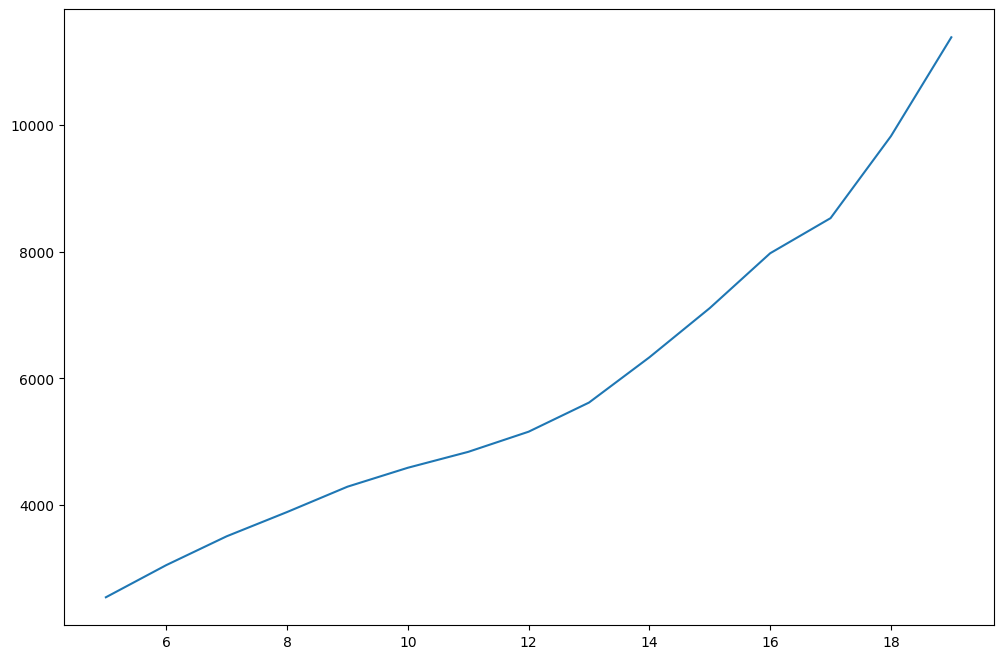

In [87]:
plt.figure(figsize=(12, 8))
plt.plot(n_topics, perplexity)

El valor de perplexity es menor a medida que se reduce la cantidad de tópicos. Esto apoyaría la hipótesis de que en realidad existen menos de seis tópicos en la base de datos.

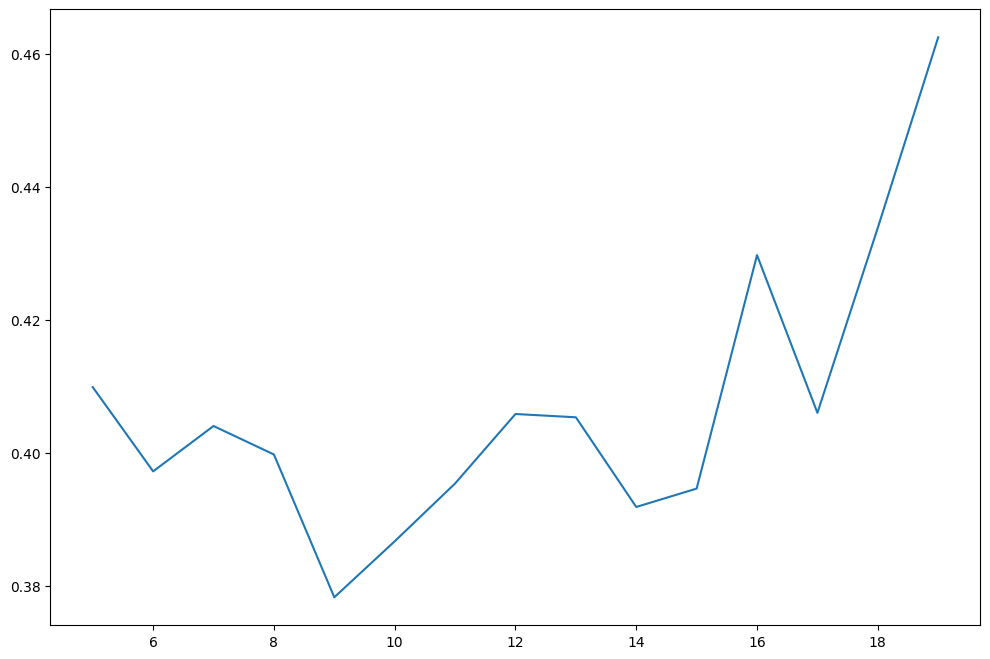

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(n_topics, coherence_lda)

In [34]:
coherence_lda

[0.4098881816870292,
 0.3972229756480781,
 0.4040420834175376,
 0.39975973250178276,
 0.3782901317124441,
 0.38670665879134203,
 0.39540088617395563,
 0.4058472785594418,
 0.4053532170475855,
 0.39187008230453485,
 0.39463183450600325,
 0.42973396767429617,
 0.4060238020837267,
 0.43384901190517894,
 0.46249403342884404]

#### LDA considerando cuatro tópicos

In [96]:
ldamodel_gensim = lda_gensim(dtm_gensim,num_topics = 4,id2word=dict_corpus, random_state=0, iterations= 50, passes=100)

In [97]:
ldamodel_gensim.print_topics(num_words=10)

[(0,
  '0.053*"sistema" + 0.048*"mayor" + 0.026*"pensión" + 0.023*"adulto" + 0.021*"adulto_mayor" + 0.015*"año" + 0.012*"mejorar" + 0.012*"persona" + 0.011*"vida" + 0.011*"edad"'),
 (1,
  '0.070*"atención" + 0.044*"espera" + 0.040*"falta" + 0.040*"especialista" + 0.040*"salud" + 0.030*"mejorar" + 0.029*"lista" + 0.028*"hora" + 0.028*"medicamento" + 0.027*"lista_espera"'),
 (2,
  '0.038*"educación" + 0.031*"salud" + 0.029*"calidad" + 0.027*"tener" + 0.023*"persona" + 0.018*"pensión" + 0.018*"sueldo" + 0.015*"acceso" + 0.015*"necesidad" + 0.014*"derecho"'),
 (3,
  '0.028*"malo" + 0.017*"faltar" + 0.017*"tener" + 0.016*"país" + 0.015*"hacer" + 0.015*"servicio" + 0.013*"alto" + 0.011*"costo" + 0.010*"personal" + 0.009*"agua"')]

In [98]:
ldamodel_gensim.get_topics().shape

(4, 4402)

In [99]:
ldamodel_gensim.get_topics().sum(axis=1)

array([1.        , 1.        , 0.99999994, 1.        ], dtype=float32)

In [100]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [101]:
df_topic_term.head()

,adulto,adulto_mayor,alcanzar,alto,costo,digno,mayor,necesitar,pensión,vida,vivir,acceso,calidad,confianza,conseguir,diagnostico,generar,ir,salud,actividad,conprender,flexibilidad,físico,incorporación,laboral,lugar,motivación,partir,permitir,trabajo,asimilar,categori,contar,cto,honorario,indefinido,junto,trabajador,consultorio,escaso,especialista,espera,hora,interminable,llevar,atención,año,esperar,exámen,igual,mes,realizar,tardía,urgencia,equipo,irrespetuoso,malo,médico,capaz,crecer,educación,joven,mantener,ojo,país,poner,uno,ver,vez,dinero,gente,migaja,morir,trabajar,especialistas,falta,medico,inversión,área,enfermo,lista,lista_espera,eficiente,sistema,mal,personal,trato,forma,inconveniente,mensual,necesidad,persona,satisfacer,sueldo,demora,interconsulta,acceder,faltar,general,posta,traslado,dar,prioridad,disminuir,aumentar,exigencia,participar,público,recurso,rural,sector,sector_rural,servicio,catastrófico,enfermedad,frente,hacer,incertidumbre,repentino,tener,actualidad,constitución,cultural,necesario,nuevo,relación,sociopolítica,correcto,desempeñar,mejorar,nivel,profesional,privado,urgente,alumno,curso,dificultar,educ,entregar,cara,universidad,mejora,centro,atender,existir,experiencia,patología,zona,destinado,realidad,aplicar,diseñar,igualdad,política,principio,rector,transversal,valor,crear,dotar,hospital,implementar,mayormente,agregar,curricular,emocional,escolar,inteligencia,malla,materia,potenciar,hora_medico,abasto,día,estudiante,respeto,respetar,agua,caro,demanda,protegido,cartera,idoneo,ministro,cobertura,cumplir,garantia,oportunidad,siguiente,institución,publico,vocación,administración,gasto,codigo,modificar,sanitario,auge,extendar,tomar,difusión,preventivo,taller,encontrar,publicar,estallido,lograr,paro,social,apoyo,asesoría,deber,deportivo,discapacidad,estado,fondo,organización,postulación,prestir,tal,velar,antiyareta,ferrocarril,provincia,regresar,extranjero,fiscalizar,restringir,institucional,politico,utilizar,animo,corbata,cuello,justicia,justificar,robo,crónico,medicamento,oferta,posterior,psd,optar,particular,suficiente,aborto,ampliar,especialización,legal,libre,reformar,seguro,universal,operación,remedio,subcidio,adecuado,vivienda,arica,parinacota,incorporar,leucemia,cefam,necer,cobrar,contrato,mínimo,pedir,peso,ser,sueldo_mínimo,gratuidad,evaluación,restriccion,bajar,publica,garantizar,población,juventud,baja,jubilar,obligado,pensión_baja,seguir,desigualdad,injusticia,cambiar,cobro,profundo,reducción,tiempo,tiempo_espera,actualizar,programa,ayudar,burocrático,contribuir,familia,impedir,objetivo,obstaculizador,proceso,tendido,hogar,jefa,jefe,latente,miedo,persistente,capital,inquietante,intervención,región,delincuente,evitar,formación,andar,calle,decir,flta,orden,querer,inteligente,modo,beneficio,económico,ingreso,mejor,obtener,ocurrir,pobre,asumir,perdido,parte,retirar,asegurar,condiciones,actual,adaptar,ayuda,caso,deporte,ejemplo,esfuerzo,formal,mundo,orientar,outdoor,participante,reflejar,regional,señalar,situación,desastre,importante,indigno,rehacer,costar,fin,llegar,producto,subir,beca,desigual,entender,precario,largo,equipado,hospitalario,recinto,judicial,juzgar,administrar,basico,ciudadanía,derecho,privatización,volver,automatización,cambio,enfrentar,manera,preescolar,problemático,real,solucionar,foco,municipio,fundamental,garante,comprometido,dispuesto,plata,haer,riqueza,afp,información,ambulancia,procecional,disponible,dispocicion,abastecimiento,bajo,colapsado,larguísimo,comuna,abandonado,acompañar,clase,clase_medio,dejar,medio,pobreza,sacar,insumo,artrosis,autismo,aspecto,infraestructura,buen,culpa,dividido,hijo,inculcar,mencionar,niño,problema,punto,ciclo,vital,pertenecer,distinto,servir,suerte,cuanto,poder,ganancia,injusto,perder,quedar,monto,recibir,solidario,momento,negligencia,pesar,alcance,cumplido,meta,surgir,chile,crédito,presupuesto,especialidad,lejano,enfer,ciudad,difícil,pequeño,fila,letra,respuesta,trasladar,acogida,casa,miserable,cambioreforma,chileno,bajisimo,entero,salario,solventar

In [102]:
df_topic_term.loc['topic0'].sort_values(ascending=False)

,topic0
sistema,0.052766
mayor,0.047817
pensión,0.026097
adulto,0.022531
adulto_mayor,0.020856
...,...
verificar,0.000021
tendido,0.000021
obstaculizador,0.000021
impedir,0.000021


In [103]:
ldamodel_gensim[dtm_gensim][5]

[(0, 0.47669807), (1, 0.47748297), (2, 0.022989105), (3, 0.022829866)]

In [104]:
cont = 0
for i in ldamodel_gensim[dtm_gensim]:
  print('doc ',cont , ': ',i)
  cont +=1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
doc  4375 :  [(0, 0.15845731), (1, 0.028824892), (2, 0.78458065), (3, 0.028137114)]
doc  4376 :  [(0, 0.03156648), (1, 0.03165095), (2, 0.90528905), (3, 0.031493478)]
doc  4377 :  [(0, 0.2889083), (1, 0.036066815), (2, 0.63930553), (3, 0.03571931)]
doc  4378 :  [(0, 0.5420732), (1, 0.3745842), (2, 0.041670848), (3, 0.041671734)]
doc  4379 :  [(0, 0.06250099), (1, 0.5580056), (2, 0.06701055), (3, 0.3124829)]
doc  4380 :  [(0, 0.022784166), (1, 0.93121135), (2, 0.023276478), (3, 0.022727989)]
doc  4381 :  [(0, 0.18818259), (1, 0.031495776), (2, 0.032593522), (3, 0.7477281)]
doc  4382 :  [(0, 0.08333725), (1, 0.08545308), (2, 0.7452433), (3, 0.08596633)]
doc  4383 :  [(0, 0.41667345), (1, 0.08333436), (2, 0.08333424), (3, 0.41665798)]
doc  4384 :  [(0, 0.74998766), (1, 0.08333726), (2, 0.08333719), (3, 0.08333786)]
doc  4385 :  [(0, 0.8433163), (1, 0.050002076), (2, 0.05472196), (3, 0.0519597)]
doc  4386 :  [(0, 0.03168606

In [105]:
# documentos representativos de un tópico dado

def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)]

asd = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim]]
df_asd = pd.DataFrame(asd, columns =['tópico', 'prop'])
df_asd['doc'] = df_asd.index

In [106]:
len(asd)

9375

In [107]:
df_asd[df_asd.tópico==0].sort_values('prop',ascending=False).head()

,tópico,prop,doc
887,0,0.969712,887
1022,0,0.948912,1022
228,0,0.945038,228
630,0,0.939807,630
7580,0,0.936533,7580


Revisamos palabras FREX

In [108]:
w=0.5    # 0 equivale a beta
import scipy as sp
from scipy.special import logsumexp

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """
    return sp.stats.rankdata(arr, method='max') / arr.size


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)

In [109]:
out_frex

array([[0.99943206, 0.99920489, 0.84162893, ..., 0.86162563, 0.41141757,
        0.41141757],
       [0.00407391, 0.00452351, 0.01656528, ..., 0.46536556, 0.22356477,
        0.22356477],
       [0.00586018, 0.00630526, 0.95643739, ..., 0.38412438, 0.37336409,
        0.37336409],
       [0.00808362, 0.0089644 , 0.0177195 , ..., 0.34036002, 0.82784043,
        0.82784043]])

In [110]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [111]:
df_topic_frex.loc['topic0'].sort_values(ascending=False)

,topic0
sistema,1.000000
mayor,0.999773
adulto,0.999432
adulto_mayor,0.999205
año,0.998978
...,...
espera,0.001360
calidad,0.000908
impedir,0.000907
atención,0.000454


In [112]:
df_topic_frex.loc['topic1'].sort_values(ascending=False)

,topic1
atención,1.000000
espera,0.999773
falta,0.999432
especialista,0.999432
lista,0.998864
...,...
vivirrevisar,0.001362
fórmula,0.001362
favo,0.001362
tener,0.000908


In [113]:
df_topic_frex.loc['topic2'].sort_values(ascending=False)

,topic2
educación,1.000000
sueldo,0.999205
derecho,0.998750
privado,0.998409
básico,0.997157
...,...
fórmula,0.001362
vivirrevisar,0.001362
mayor,0.001361
sistema,0.000908


In [114]:
df_topic_frex.loc['topic3'].sort_values(ascending=False)

,topic3
malo,1.000000
faltar,0.999773
alto,0.999091
personal,0.998750
vocación,0.998182
...,...
fórmula,0.001361
favo,0.001361
mejorar,0.001361
atención,0.000908


Las etiquetas de los tópicos son:

Tópico 0 es pensiones

Tópico 1 es salud

Tópico 2 es derechos sociales

Tópico 3 es mala calidad de servicios

#### Clustering

### Conclusiones